In [1]:
!nvidia-smi

Wed Sep 27 10:06:49 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0     Off |                  N/A |
|  0%   34C    P8    14W / 200W |      0MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:03:00.0     Off |                  N/A |
|  0%   34C    P8    15W / 200W |      0MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
import sys
import os

sys.path.append(os.path.join("..", "..", ".."))
import ecg.dataset as ds
from ecg.batch import ModelEcgBatch

%env CUDA_VISIBLE_DEVICES=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
config.gpu_options.allow_growth=True

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=0


## Train pipeline

In [3]:
fft_train_pipeline = (ds.Pipeline()
                      .load(fmt="wfdb", components=["signal", "meta"])
                      .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                            fmt="csv", components="target")
                      .drop_labels(["~"])
                      .replace_labels({"N": "NO", "O": "NO"})
                      .random_resample_signals("normal", loc=300, scale=10)
                      .drop_short_signals(4000)
                      .segment_signals(3000, 3000)
                      .binarize_labels()
                      .signal_transpose([0, 2, 1])
                      .ravel()
                      .train_on_batch('fft_inception', metrics=f1_score, average='macro')
                      .run(batch_size=300, shuffle=True,
                           drop_last=True, n_epochs=10, prefetch=0, lazy=True))

In [4]:
index = ds.FilesIndex(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds = ds.Dataset(index, batch_class=ModelEcgBatch)
eds.cv_split(0.8)
fft_trained = (eds.train >> fft_train_pipeline).run()

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Show loss and metric on train

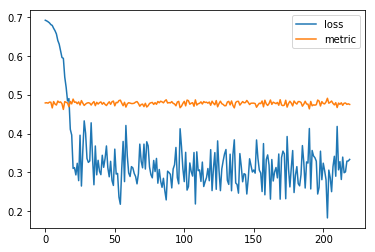

In [5]:
plt.plot(fft_trained.get_model_by_name('fft_inception').hist['train_loss'], label='loss')
plt.plot(fft_trained.get_model_by_name('fft_inception').hist['train_metric'], label='metric')
plt.legend()
plt.show()

## Save model

In [6]:
(fft_trained.get_model_by_name("fft_inception")
            .save("/notebooks/e_illarionov/ecg_repo/model_dump/fft_latest"))

## Test pipeline

In [7]:
fft_test_pipeline = (ds.Pipeline()
                     .import_model('fft_inception', fft_trained)
                     .load(fmt="wfdb", components=["signal", "meta"])
                     .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                           fmt="csv", components="target")
                     .drop_labels(["~"])
                     .replace_labels({"N": "NO", "O": "NO"})
                     .random_resample_signals("normal", loc=300, scale=10)
                     .drop_short_signals(4000)
                     .segment_signals(3000, 3000)
                     .binarize_labels()
                     .signal_transpose([0, 2, 1])
                     .ravel()
                     .test_on_batch('fft_inception', metrics=f1_score, average='macro')
                     .run(batch_size=300, shuffle=True, drop_last=True,
                          n_epochs=1, prefetch=0, lazy=True))

In [8]:
res_test = (eds.test >> fft_test_pipeline).run()

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Show loss and metric on test


In [10]:
print(np.mean(res_test.get_model_by_name('fft_inception').hist['val_loss']))
print(np.mean(res_test.get_model_by_name('fft_inception').hist['val_metric']))

0.317212
0.474711749362


## Predict pipeline

In [11]:
config = {'path': "/notebooks/e_illarionov/ecg_repo/model_dump/fft_latest"}

fft_predict_pipeline = (ds.Pipeline(config={'fft_inception': config})
                        .init_model('fft_inception')
                        .init_variable("prediction", [])
                        .load(fmt="wfdb", components=["signal", "meta"])
                        .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv", fmt="csv", components="target")
                        .drop_labels(["~"])
                        .replace_labels({"N": "NO", "O": "NO"})
                        .random_resample_signals("normal", loc=300, scale=10)
                        .drop_short_signals(4000)
                        .segment_signals(3000, 3000)
                        .binarize_labels()
                        .signal_transpose([0, 2, 1])
                        .ravel()
                        .predict_on_batch('fft_inception')
                        .run(batch_size=100, shuffle=False, drop_last=False,
                             n_epochs=1, prefetch=0, lazy=True))

In [12]:
res_predict = (eds.test >> fft_predict_pipeline).run()

In [13]:
res_predict.get_variable('prediction')

[array([[ 0.50427443,  0.4957256 ],
        [ 0.50163156,  0.49836844],
        [ 0.50357223,  0.4964278 ],
        [ 0.50756741,  0.49243265],
        [ 0.50392878,  0.49607116],
        [ 0.50857091,  0.49142909],
        [ 0.50330007,  0.4966999 ],
        [ 0.50309193,  0.49690804],
        [ 0.50548041,  0.49451953],
        [ 0.50405067,  0.49594933],
        [ 0.50588965,  0.49411032],
        [ 0.50533307,  0.4946669 ],
        [ 0.50411683,  0.4958832 ],
        [ 0.50718635,  0.49281365],
        [ 0.50387752,  0.49612251],
        [ 0.5044297 ,  0.49557036],
        [ 0.50554216,  0.49445778],
        [ 0.50654036,  0.49345964],
        [ 0.50299072,  0.49700931],
        [ 0.50262791,  0.49737215],
        [ 0.50571084,  0.49428916],
        [ 0.50634444,  0.49365562],
        [ 0.5063777 ,  0.49362227],
        [ 0.50548947,  0.4945105 ],
        [ 0.50772196,  0.49227798],
        [ 0.50359172,  0.49640825],
        [ 0.50316876,  0.49683127],
        [ 0.50550532,  0.494